# Transfer Learning with TensorFlow

*Transfer learning* is the practice of starting with a network that has already been trained, and then applying that network to your own problem.

Because neural networks can often take days or even weeks to train, transfer learning (i.e. starting with a network that somebody else has already spent a lot of time training) can greatly shorten training time.

### Setup
In order to complete this lab, install Python 3, tensorflow, numpy, scipy, matplotlib, and pillow.

## AlexNet
Here, you're going to practice transfer learning with [AlexNet](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiG34CS7vHPAhVKl1QKHW2JAJkQFggcMAA&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf&usg=AFQjCNFlGsSmTUkJw0gLJ0Ry4cm961B7WA&bvm=bv.136593572,d.cGw).

AlexNet is a popular base network for transfer learning because its structure is relatively straightforward, it's not too big, and it performs well empirically.

Here is a TensorFlow implementation of AlexNet (adapted from [Michael Guerhoy and Davi Frossard](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/)):

In [1]:
from numpy import *
import os
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

import tensorflow as tf

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]

net_data = load("bvlc-alexnet.npy", encoding="latin1").item()

def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])

x = tf.placeholder(tf.float32, (None,) + xdim)
resized = tf.image.resize_images(x, (227, 227))

def features():

    #conv1
    #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
    conv1W = tf.Variable(net_data["conv1"][0])
    conv1b = tf.Variable(net_data["conv1"][1])
    conv1_in = conv(resized, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    #lrn1
    #lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1,
                                                      depth_radius=radius,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      bias=bias)

    #maxpool1
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


    #conv2
    #conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2W = tf.Variable(net_data["conv2"][0])
    conv2b = tf.Variable(net_data["conv2"][1])
    conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)


    #lrn2
    #lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2,
                                                      depth_radius=radius,
                                                      alpha=alpha,
                                                      beta=beta,
                                                      bias=bias)

    #maxpool2
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #conv3
    #conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3W = tf.Variable(net_data["conv3"][0])
    conv3b = tf.Variable(net_data["conv3"][1])
    conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)

    #conv4
    #conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4W = tf.Variable(net_data["conv4"][0])
    conv4b = tf.Variable(net_data["conv4"][1])
    conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)


    #conv5
    #conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5W = tf.Variable(net_data["conv5"][0])
    conv5b = tf.Variable(net_data["conv5"][1])
    conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)

    #maxpool5
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #fc6
    #fc(4096, name='fc6')
    fc6W = tf.Variable(net_data["fc6"][0])
    fc6b = tf.Variable(net_data["fc6"][1])
    fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

    #fc7
    #fc(4096, name='fc7')
    fc7W = tf.Variable(net_data["fc7"][0])
    fc7b = tf.Variable(net_data["fc7"][1])
    fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)
    return fc7

def logits():
    #fc8
    #fc(1000, relu=False, name='fc8')
    fc8W = tf.Variable(net_data["fc8"][0])
    fc8b = tf.Variable(net_data["fc8"][1])
    fc8 = tf.nn.xw_plus_b(features(), fc8W, fc8b, name='logits')
    return fc8

def probabilities():
    #prob
    #softmax(name='prob'))
    return tf.nn.softmax(logits())

## ImageNet Inference

![alt text](poodle.png "Poodle")
![alt text](weasel.png "Weasel")

To start, run a few ImageNet images through the network, and verify that the network classifies them correctly.

In [2]:
# NOTE: You don't need to edit this code.

from caffe_classes import class_names

# Initialize the Model
prob = probabilities()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# Read Images
im1 = (imread("poodle.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)

im2 = (imread("weasel.png")[:,:,:3]).astype(float32)
im2 = im2 - mean(im2)

# Run Inference
t = time.time()
output = sess.run(prob, feed_dict = {x:[im1,im2]})

# Print Output
for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    for i in range(5):
        print("%s: %.3f" % (class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]]))
    print()

print("Time: %.3f seconds" % (time.time()-t))

Image 0
miniature poodle: 0.389
toy poodle: 0.223
Bedlington terrier: 0.173
standard poodle: 0.150
komondor: 0.026

Image 1
weasel: 0.331
polecat, fitch, foulmart, foumart, Mustela putorius: 0.280
black-footed ferret, ferret, Mustela nigripes: 0.210
mink: 0.081
Arctic fox, white fox, Alopex lagopus: 0.027

Time: 0.545 seconds


## Traffic Sign Inference
![alt text](construction.jpg "Construction Sign")
![alt text](stop.jpg "Stop Sign")

Next, run two of the traffic sign images through the network, and see how well the classifier performs.

You'll notice, however, that the AlexNet model expects a 227x227x3 pixel image, whereas the traffic sign images are 32x32x3 pixels.

In order to feed our the traffic sign images into AlexNet, you'll need to resize the images to the dimensions that AlexNet expects.

You could resize the images outside of this program, but that would make for a huge collection of images. Instead, use the `tf.images.resize_images()` method to resize the images within the model.

In [3]:
from caffe_classes import class_names

# TODO: Update the xdim, x, and resized variables to accomodate 32x32x3 pixel images.
xdim = (32, 32, 3)
x = tf.placeholder(tf.float32, (None,) + xdim)
resized = tf.image.resize_images(x, (227, 227))

# ydim = train_y.shape[1]

# NOTE: You don't need to edit the code below.
# Initialize the Model
prob = probabilities()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# Read Images
im1 = (imread("construction.jpg")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)

im2 = (imread("stop.jpg")[:,:,:3]).astype(float32)
im2 = im2 - mean(im2)

# Run Inference
t = time.time()
output = sess.run(prob, feed_dict = {x:[im1,im2]})

# Print Output
for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    for i in range(5):
        print("%s: %.3f" % (class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]]))
    print()

print("Time: %.3f seconds" % (time.time()-t))
sess.close()

Image 0
screen, CRT screen: 0.051
digital clock: 0.041
laptop, laptop computer: 0.030
balance beam, beam: 0.027
parallel bars, bars: 0.023

Image 1
digital watch: 0.395
digital clock: 0.275
bottlecap: 0.115
stopwatch, stop watch: 0.104
combination lock: 0.086

Time: 0.047 seconds


## Feature Extraction
The problem is that AlexNet was trained on the [ImageNet](http://www.image-net.org/) database, which has 1000 classes of images. You can see the classes in the `caffe_classes.py` file. None of those classes involves traffic signs.

In order to successfully classify our traffic sign images, you need to remove the final, 1000-neuron classification layer and replace it with a new, 43-neuron classification layer.

This is called feature extraction, because you're basically extracting the images features captured by the penultimate layer, and passing them to a new classification layer.

In [4]:
# TODO: Redefine the logits() function to create a new fully-connected layer.
def logits():
    """
    Redefined fully-connected layer for 43 classes
    """
    #fc8
    #fc(1000, relu=False, name='fc8')
    fc8W = v = tf.Variable(tf.truncated_normal([net_data["fc8"][0].shape[0], 43], stddev=0.005))
    fc8b = tf.Variable(tf.zeros(43))
    fc8 = tf.nn.xw_plus_b(features(), fc8W, fc8b, name='logits')
    return fc8

# NOTE: You don't need to edit the code below.
# Initialize the Model

prob = probabilities()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# Read Images
im1 = (imread("construction.jpg")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)

im2 = (imread("stop.jpg")[:,:,:3]).astype(float32)
im2 = im2 - mean(im2)

# Run Inference
t = time.time()
output = sess.run(prob, feed_dict = {x:[im1,im2]})

# Print Output
for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print("Image", input_im_ind)
    for i in range(5):
        print("%s: %.3f" % (inds[-1-i], output[input_im_ind, inds[-1-i]]))
    print()

print("Time: %.3f seconds" % (time.time()-t))
sess.close()

Image 0
14: 0.043
10: 0.040
6: 0.040
39: 0.037
21: 0.033

Image 1
14: 0.045
6: 0.041
39: 0.038
21: 0.037
11: 0.035

Time: 0.043 seconds


## Training the Feature Extractor
The feature extractor you just created works, in the sense that data will flow through the network and result in predictions.

But the predictions aren't accurate, because you haven't yet trained the new classification layer.

In order to do that, you'll need to read in the training dataset and train the network with cross entropy.

Notice that in the network definition (look in the `features()` function), all of the layers are set to `trainable=False`. This freezes the weights of those layers, so you keep the trained AlexNet features and only train the final classification layer. This also makes training faster.

Training AlexNet (even just the final layer!) can take a little while, so it can be helpful to try out your code using only a small portion of the training set. Once you're confident your implementation works, you can train use the entire training dataset to train the network.

In [5]:
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# TODO: Load the training dataset.
# TODO: Implement load the data here.
# Load pickled data
import pickle
import csv
import os

# TODO: fill this in based on where you saved the training and testing data
# training_file = '../../traffic-signs/traffic-signs-data/train.p'
training_file = 'train.p'
testing_file = '../../traffic-signs/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Make dictionary of sign names from CSV file
with open('../../traffic-signs/signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    sign_names = dict((int(n),label) for n, label in reader)

cls_numbers, cls_names = zip(*sign_names.items())

n_classes = len(set(y_train))

flat_img_size = 32*32*3

Using TensorFlow backend.


In [6]:
# TODO: Pre-process the input data.
def normalize_color(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = +0.5
    
    Xmin = 0.0
    Xmax = 255.0

    norm_img = np.empty_like(image_data, dtype=np.float32)

    norm_img = a + (image_data - Xmin)*(b-a)/(Xmax - Xmin)
    
    return norm_img

X_train = normalize_color(X_train)
X_test = normalize_color(X_test)

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

import matplotlib.pyplot as plt
import random
import textwrap

def plot_images(images, cls_true, cls_pred=None, count=9, num_per_row=3, randomize=True):
    ctr = 0
    global sign_names
    
    if randomize:
        iterator = random.sample(range(len(images)), count)
    else:
        iterator = range(min(count, len(images)))
        
    for i in iterator:
        X, y_true = images[i,:], cls_true[i]

        if ctr % num_per_row == 0:
            # Create new row
            plt.figure()
            
        plt.subplot(1, num_per_row, (ctr % num_per_row) + 1)
        ax = plt.gca()
        plt.imshow(X)
        
        # Show the classes as the label on the x-axis.
        true_label = textwrap.fill(sign_names[y_true], 25)
        if cls_pred is not None:
            y_pred = cls_pred[i]
            
            pred_label = textwrap.fill(sign_names[y_pred], 25)
            ax.set_xlabel('True : {0} \n Pred: {1}'.format(true_label, pred_label))
        else:
            ax.set_xlabel(true_label)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

        ctr += 1

class Dataset():
    """
    A class that provides an unlimited supply of batched data from a given dataset
    """
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.length = len(features)
        self.reset()
    
    def reset(self):
        self.ctr = 0
        
    def next_batch(self, batch_size):
        """
        Returns an a batch of data, resetting to beginning any time it reaches the end
        """
        indices = np.arange(self.ctr, self.ctr+batch_size) % self.length
        self.ctr += batch_size
        self.ctr = self.ctr % len(self.features)
        
        return self.features[indices], self.labels[indices]

In [20]:
from tqdm import tqdm_notebook
def train_model(session, optimizer, cost, model, train_data, num_iterations, save_best=True, valid_data=None, batch_size=64, keep_prob=0.5):
    iter_pbar = tqdm_notebook(range(num_iterations), unit=' iterations')

    if save_best:
        global saver, save_dir
        
    best_validation_accuracy = 0.0
    last_improvement = 0
    require_improvement = 1000
    
    save_path = save_dir + 'best_validation'
    train_acc = 0.0
    valid_acc = 0.0
    improved_str = ''
    for ctr in iter_pbar:
        batch_X, batch_y = train_data.next_batch(batch_size)

        feed_dict_train = {x: batch_X, y: batch_y}
        _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)

        if (ctr % 100 == 0) or (ctr == (num_iterations - 1)):
            train_acc = session.run(accuracy, feed_dict={x: batch_X, y: batch_y})
            if valid_data is not None:
                valid_acc = get_validation_accuracy(session, model)
            else:
                valid_acc = 0.0

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = ctr

                # Save all variables of the TensorFlow graph to file.
                if save_best:
                    saver.save(sess=session, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # Shows that no improvement was found.
                improved_str = ''

        pbar_desc = 'c={0:>6.4}, train_acc={1:>6.2%}, valid_acc={2:>6.2%}{3}, best={4:>6.2%}'.format(c,
                                                                                          train_acc,
                                                                                          valid_acc,
                                                                                          improved_str,
                                                                                          best_validation_accuracy)
        iter_pbar.set_description(pbar_desc)
    print("Last improvement at "+str(last_improvement+1))

def get_accuracy(session, model, data, batch_size=421):
    # Number of images in the test-set.
    num_test = data.length

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        batch_images = data.features[i:j, :]

        # Get the associated labels.
        batch_labels = data.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: batch_images,
                     y: batch_labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(model, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    
    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(data.labels, axis=1)
    # Create a boolean array whether each image is correctly classified.
    correct = np.equal(cls_true, cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = sum(correct)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    return acc, cls_pred

def get_validation_accuracy(session, model):
    valid_acc, _ = get_accuracy(session, model, valid_data, batch_size=64)
    return valid_acc

def get_train_accuracy(session, model):
    train_acc, _ = get_accuracy(session, model, train_data, batch_size=64)
    return train_acc

def print_accuracy(session, model):
    train_acc = get_train_accuracy(session, model)
    valid_acc = get_validation_accuracy(session, model)
    
    print('Training Accuracy : %.2f %%' % (train_acc*100))
    print('Validation Accuracy : %.2f %%' % (valid_acc*100))
    
def print_test_accuracy(session, model):
    test_acc, _ = get_accuracy(session, model, test_data, batch_size=42)
    print('Test Accuracy : %.2f %%' % (test_acc*100))
    
def plot_wrong_tests(session, model):
    test_acc, cls_pred = get_accuracy(session, model, test_data, batch_size=42)
    cls_true = np.argmax(test_data.labels, axis=1)
    print('Test Accuracy : %.2f %%' % (test_acc*100))
    
    wrong = np.not_equal(cls_true, cls_pred)
    
    plot_images(test_data.features[wrong]+0.5, cls_true[wrong], cls_pred[wrong])

In [9]:
learning_rate = 0.0001
batch_size = 64
save_dir = 'checkpoints/'

# TODO: Once you are confident that the training works, update the training set to use all of the data.
# train_features = X_train[:1000]
# train_labels = Y_train[:1000]
train_features = X_train
train_labels = Y_train

train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.25,
    random_state=0xdeadbeef)

train_data = Dataset(train_features, train_labels)
valid_data = Dataset(valid_features, valid_labels)
test_data = Dataset(X_test, Y_test)

In [10]:
# TODO: Train the network.
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None,) + xdim, name='x')
resized = tf.image.resize_images(x, (227, 227))

y = tf.placeholder(tf.float32, shape=(None, n_classes), name='labels')

# cross_entropy = -tf.reduce_sum(y * tf.log(prob), reduction_indices=1)
alexnet_logits = logits()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(alexnet_logits, y), name='cost')

prob = tf.nn.softmax(alexnet_logits)
prob_cls = tf.argmax(prob, dimension=1)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prob, 1), tf.argmax(y, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

tf.add_to_collection('train_ops', optimizer)
tf.add_to_collection('train_ops', cost)
tf.add_to_collection('train_ops', accuracy)
tf.add_to_collection('train_ops', prob_cls)

tf.add_to_collection('inputs', x)
tf.add_to_collection('inputs', y)

In [11]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [12]:
train_model(sess, optimizer, cost, prob_cls, train_data, 1000, valid_data=valid_data, batch_size=batch_size, save_best=False)


Last improvement at 901


In [14]:
train_model(sess, optimizer, cost, prob_cls, train_data, 4000, valid_data=valid_data, batch_size=batch_size, save_best=False)


Last improvement at 2701


Test Accuracy : 95.81 %
Test Accuracy : 95.81 %


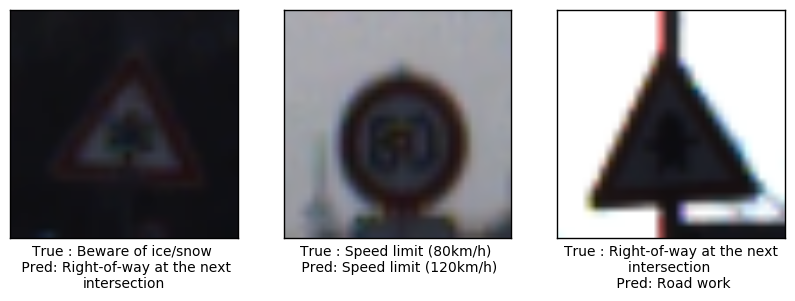

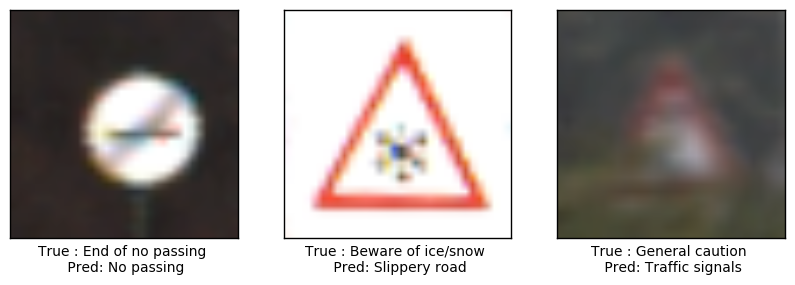

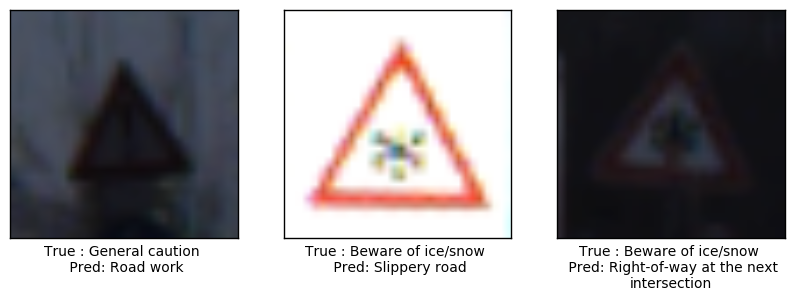

In [21]:
# print_accuracy(sess, prob_cls)
# print_test_accuracy(sess, prob_cls)
plot_wrong_tests(sess, prob_cls)

In [ ]:
1+1

**Validation Accuracy:** 98.11% after 1k, 99.79% after 5k
**Test Accuracy:** 99.33% after 1k,

## Congratulations!
You've trained AlexNet as a feature extractor!

Don't be discouraged if your validation accuracy still isn't as high as you'd like.

Coming up, you'll explore other networks to use for transfer learning, as well as approaches to improve accuracy.